## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import gensim
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import chain
import string
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from datetime import datetime
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from dateutil import parser
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Data

In [3]:
root_dir = '/content/drive/MyDrive/audace_trial/corpus/english_modern/canadian_newstream'

In [4]:
out_dir = "/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/"

# Data Cleaning

In [5]:
def get_files(root_dir):
  # Define a list to store the text from .rtf files
  file_list = []

  # Recursively search for files in the root directory and its subdirectories
  for subdir, dirs, files in os.walk(root_dir):
      for fil in files:
          obj = {}
          file_path = os.path.join(subdir, fil)
          seg = subdir.split('/')
          obj['term'] = seg[-1]
          f = open(file_path, 'r')
          text = f.read()
          obj['text'] = text
          f.close
          file_list.append(obj)
  return file_list

In [6]:
def extract_doc (file_list):
  regex_pattern = "(.*?)Database:"
  doc_list = []
  for obj in file_list:
    matches = re.finditer(regex_pattern, obj['text'], re.DOTALL)
    for mat in matches:
      doc = {}
      extracted_text = mat.group(1).strip()
      doc['text'] = extracted_text
      doc['term'] = obj['term']
      doc_list.append(doc)
  return doc_list

In [7]:
def documentation(doc_list):
  cont_list = []
  pattern0 = r"Full text:(.*?)Location:"
  pattern1 = r"document ID:(.*?)\n"
  pattern2 = r"Source type:(.*?)\n"
  pattern3 = r"Publication date:(.*?)\n"
  pattern4 = r"^.*?Subject:.*?$"
  pattern5 = r"^.*?Business indexing term:.*?$"
  subject_pattern = r"Subject:(.*?)\n"
  subject = ["NA"]
  source = "NA"
  date = "NA"
  for doc in doc_list:
    t = {}
    m0 = re.search(pattern0, doc['text'], re.DOTALL)
    cont = m0.group(1).strip()
    m1 = re.search(pattern1, doc['text'], re.DOTALL)
    id = m1.group(1).strip()
    m2 = re.search(pattern2, doc['text'], re.DOTALL)
    if m2:
      source = m2.group(1).strip()
    m3 = re.search(pattern3, doc['text'], re.DOTALL)
    if m3:
      date = m3.group(1).strip()
    m6 = re.search(subject_pattern, doc['text'], re.DOTALL)
    if m6:
      subject = m6.group(1).strip()
      subject = subject.split("; ")
    m4 = re.search(pattern4, cont, re.DOTALL)
    m5 = re.search(pattern5, cont, re.DOTALL)
    if m5:
      cont = re.sub(pattern5, "", cont, flags=re.MULTILINE)
    if m4:
      cont = re.sub(pattern4, "", cont, flags=re.MULTILINE)
    t['term'] = doc['term']
    t['full_text'] = cont
    t['date'] = date
    t['source'] = source
    t['id'] = id
    t['subject'] = subject
    cont_list.append(t)
  return cont_list



In [8]:
def rm_duplicates(cont_list):
  unique_data = []
  seen_texts = set()
  for entry in cont_list:
      full_text = entry['full_text'][:100]
      if full_text not in seen_texts:
          unique_data.append(entry)
          seen_texts.add(full_text)
  return unique_data

In [9]:
def remove_links(text):
    pattern = r'\( https?://[^\s()]+ \)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

In [10]:
def export_cont(out_dir, unique_list):
    for f in unique_list:
      source = f['source']
      term = f['term']
      date = f['date']
      if '/'in date:
        date = f['date'].replace('/', '-')
      id = f['id']
      cont = f['full_text']
      file_name = out_dir + source + "_" + term + "_" + date + "_" + id + ".txt"
      print(file_name)
      f = open(file_name, "w")
      f.write(cont)
      f.close

# Cleaning

In [11]:
file_list = get_files(root_dir)

In [12]:
doc_list = extract_doc(file_list)

In [13]:
cont_list = documentation(doc_list)

In [14]:
unique_list = rm_duplicates(cont_list)

In [15]:
unique_list[100]

{'term': 'flood',
 'full_text': 'As much of a nightmare as the floods of 2017 were to live through, the ongoing horror that some survivors are still experiencing is arguably worse. Almost an entire year after the floods that ravaged Pierrefonds, Rigaud, Gatineau and other communities in the western part of Quebec, some families remain in hotel rooms, living with relatives or relying on aid. They are exhausted in every sense of the word. All they want now is their home.\nWhile the wheels of bureaucracy turn frustratingly slowly, there is one proposed measure that could help get them back on their feet: More than 600 people have signed a petition calling on the government to allow victims of natural disasters to use money from their Registered Retirement Savings Plan to rebuild or relocate, without penalty. The petition called "upon the Minister of National Revenue to amend the law governing RRSPs so that anyone who has experienced a natural disaster such as a tornado, fire, flood or ear

In [16]:
len(unique_list)

1559

In [17]:
export_cont(out_dir, unique_list)

/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or W ebsite_flood_Sep 29, 2020_2447104249.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Wire Feed_flood_Sep 28, 2020_2447365132.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_May 14, 2020_2402597693.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_May 8, 2020_2400120923.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_Apr 3, 2020_2385834748.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_Apr 2, 2020_2385831916.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_Apr 2, 2020_2385821376.txt
/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/Blog, Podcast, or Website_flood_Apr 2, 2020_2385757794.txt
/content/dri

In [21]:
file_list = os.listdir(out_dir)
len(file_list)

1559

In [26]:
unique_list[1555]

{'term': 'freezing_rain',
 'full_text': '? Much of Ontario and large parts of Quebec are being battered by a massive winter storm that\'s whipping up icy winds and dumping near-record amounts of snow.\nEnvironment Canada warned Sunday that the "hit and run" storm could drop up about 30 centimetres of snow in Ontario and as many as 60 centimetres in some areas in Quebec.\n"It\'s a one-day wonder here for Ontario, that\'s the good news about it," said Environment Canada senior climatologist Dave Phillips.\nAir travel was crippled Sunday by the storm and flights at Toronto\'s Pearson International Airport - the busiest in the country - were cut by 50 per cent. Most flights from the United States, but also from Ottawa, Windsor, London and Kingston, Ont., were cancelled and many international flights were delayed.\nThe Greater Toronto Airport Authority and airport authorities in Montreal were advising travellers to check ahead with their airline. VIA Rail said all trains were operating norm

In [23]:
df = pd.DataFrame()

# Iterate over each dictionary in the list
for item in unique_list:
    # Extract the keys and values from the dictionary
    data = {k.capitalize(): v if k != 'subject' else ', '.join(v) for k, v in item.items()}

    # Append the dictionary as a new row to the dataframe
    df = df.append(data, ignore_index=True)

# Print the resulting dataframe
print(df)

<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

               Term                                          Full_text  \
0             flood  QUEBEC - As Quebec health officials scrambled ...   
1             flood  As Quebec health officials scrambled in late s...   
2             flood  QUEBEC - The province wants to help Montreal o...   
3             flood  Within 48 hours of the provincial government s...   
4             flood  Verdun Hospital has been hit with the most sev...   
...             ...                                                ...   
1554  freezing_rain  Power outages and flight disruptions reported ...   
1555  freezing_rain  ? Much of Ontario and large parts of Quebec ar...   
1556  freezing_rain  Close to 30,000 Quebecers were left without po...   
1557  freezing_rain  Southern Ontario was hit with a winter storm T...   
1558  freezing_rain  The first severe snowstorm to hit Central Cana...   

              Date                      Source          Id  \
0     Sep 29, 2020  Blog, Podcast, or W ebsite  2

<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-23-ddc87abe49a4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [24]:
df

,Term,Full_text,Date,Source,Id,Subject
0,flood,QUEBEC - As Quebec health officials scrambled ...,"Sep 29, 2020","Blog, Podcast, or W ebsite",2447104249,"Public health, Coronaviruses, Pandemics, Masks..."
1,flood,As Quebec health officials scrambled in late s...,"Sep 28, 2020",Wire Feed,2447365132,"Public health, Coronaviruses, Pandemics, Masks..."
2,flood,QUEBEC - The province wants to help Montreal o...,"May 14, 2020","Blog, Podcast, or Website",2402597693,"Public transportation, Coronaviruses, Pandemic..."
3,flood,Within 48 hours of the provincial government s...,"May 8, 2020","Blog, Podcast, or Website",2400120923,"Online sales, Coronaviruses, Books, COVID-19"
4,flood,Verdun Hospital has been hit with the most sev...,"Apr 3, 2020","Blog, Podcast, or Website",2385834748,"Hospitals, Patients, Severe acute respiratory ..."
...,...,...,...,...,...,...
1554,freezing_rain,Power outages and flight disruptions reported ...,"Apr 12, 2013","Blog, Podcast, or Website",2384101650,"School buses, Customer services, Ice, School b..."
1555,freezing_rain,? Much of Ontario and large parts of Quebec ar...,"Dec 16, 2007","Blog, Podcast, or Website",2386078040,"Storms, Airports, Snow removal, Rain, Roads & ..."
1556,freezing_rain,"Close to 30,000 Quebecers were left without po...","Jan 18, 2006","Blog, Podcast, or Website",2386456044,Rain
1557,freezing_rain,Southern Ontario was hit with a winter storm T...,"Dec 23, 2004","Blog, Podcast, or Website",2386692871,"Precipitation, Airline scheduling, Christmas, ..."


# Visualization

In [18]:
def vis_source(unique_list):
  # Extract the values of the "source" key into a separate list
  source_list = [d["source"] for d in unique_list]

  # Count the occurrences of each value
  counts = Counter(source_list)

  # Get the unique sources and their counts
  sources = list(counts.keys())
  counts = list(counts.values())

  print(sources)
  print(counts)

  # Create a bar chart
  plt.bar(sources, counts)
  plt.xlabel("Source")
  plt.ylabel("Count")
  plt.title("Occurrences of Sources")
  for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha="center", va="bottom")
  plt.show()

In [19]:
def vis_term(unique_list):
  # Extract the values of the "source" key into a separate list
  source_list = [d["term"] for d in unique_list]

  # Count the occurrences of each value
  counts = Counter(source_list)

  # Get the unique sources and their counts
  sources = list(counts.keys())
  counts = list(counts.values())

  print(sources)
  print(counts)

  # Create a bar chart
  plt.bar(sources, counts)
  plt.xlabel("Term")
  plt.ylabel("Count")
  plt.title("Occurrences of Terms")
  for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha="center", va="bottom")
  plt.show()

In [20]:
def vis_date(data):
    # Extract the date strings from the list of dictionaries
    date_strings = [d['date'] for d in data]

    # Function to parse the date strings
    def parse_date(date_str):
        try:
            # Attempt to parse the date string using dateutil.parser
            return parser.parse(date_str)
        except ValueError:
            # Ignore the "May/Jun 2003" format and return None
            return None

    # Parse the date strings and convert them into datetime objects
    dates = [parse_date(date_str) for date_str in date_strings]

    # Remove None values (for "May/Jun 2003" format) from the dates list and corresponding dictionaries
    valid_dates = [date for date in dates if date is not None]
    valid_data = [d for d, date in zip(data, dates) if date is not None]

    # Sort the list of dictionaries based on the parsed date values
    sorted_data = [d for _, d in sorted(zip(valid_dates, valid_data), key=lambda x: x[0])]

    # Extract the sorted dates
    sorted_dates = [date.strftime('%b %d, %Y') for date in valid_dates]

    # Count the frequency of each date
    date_counts = Counter(sorted_dates)

    # Get the unique sorted dates and their frequencies
    unique_dates = list(date_counts.keys())
    frequencies = list(date_counts.values())

    # Sort the unique dates in chronological order
    unique_dates_sorted = sorted(unique_dates, key=lambda x: parser.parse(x))

    # Get the frequencies in the same order as the sorted dates
    frequencies_sorted = [date_counts[date] for date in unique_dates_sorted]

    # Plot the timeline as a scatter plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(unique_dates_sorted, frequencies_sorted, color='blue', s=50)
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.set_title('Timeline Visualization')
    ax.set_xticks([unique_dates_sorted[0], unique_dates_sorted[-1]])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Data Analysis

['Blog, Podcast, or W ebsite', 'Wire Feed', 'Blog, Podcast, or Website', 'Newspaper', 'Magazine', 'Blog, P odcast, or Website', 'Blog, Pod cast, or Website', 'Blog, Podcast , or Website', 'Blog, Podc ast, or Website', 'Blog, Podcast, or We bsite', 'Blog, Podcas t, or Website', 'Blog, Podcast, or Websi te']
[1, 5, 1089, 452, 1, 2, 3, 1, 2, 1, 1, 1]


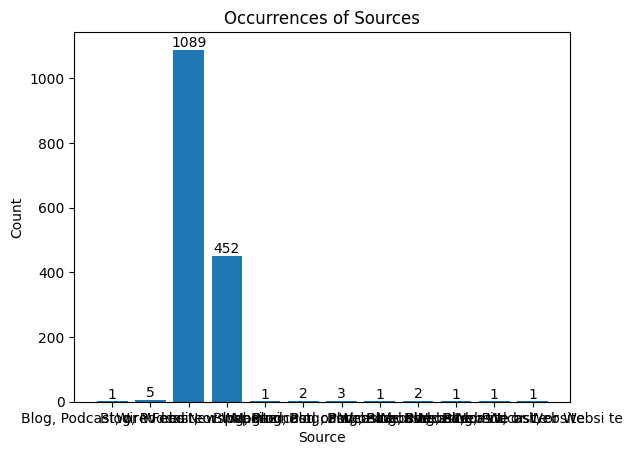

In [ ]:
vis_source(unique_list)

['flood', 'forestfire', 'blizzard', 'heatwave', 'freezing_rain', 'storm']
[138, 197, 186, 424, 373, 241]


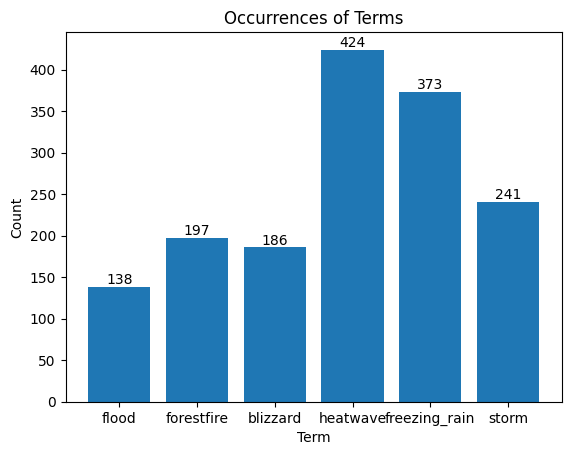

In [ ]:
vis_term(unique_list)

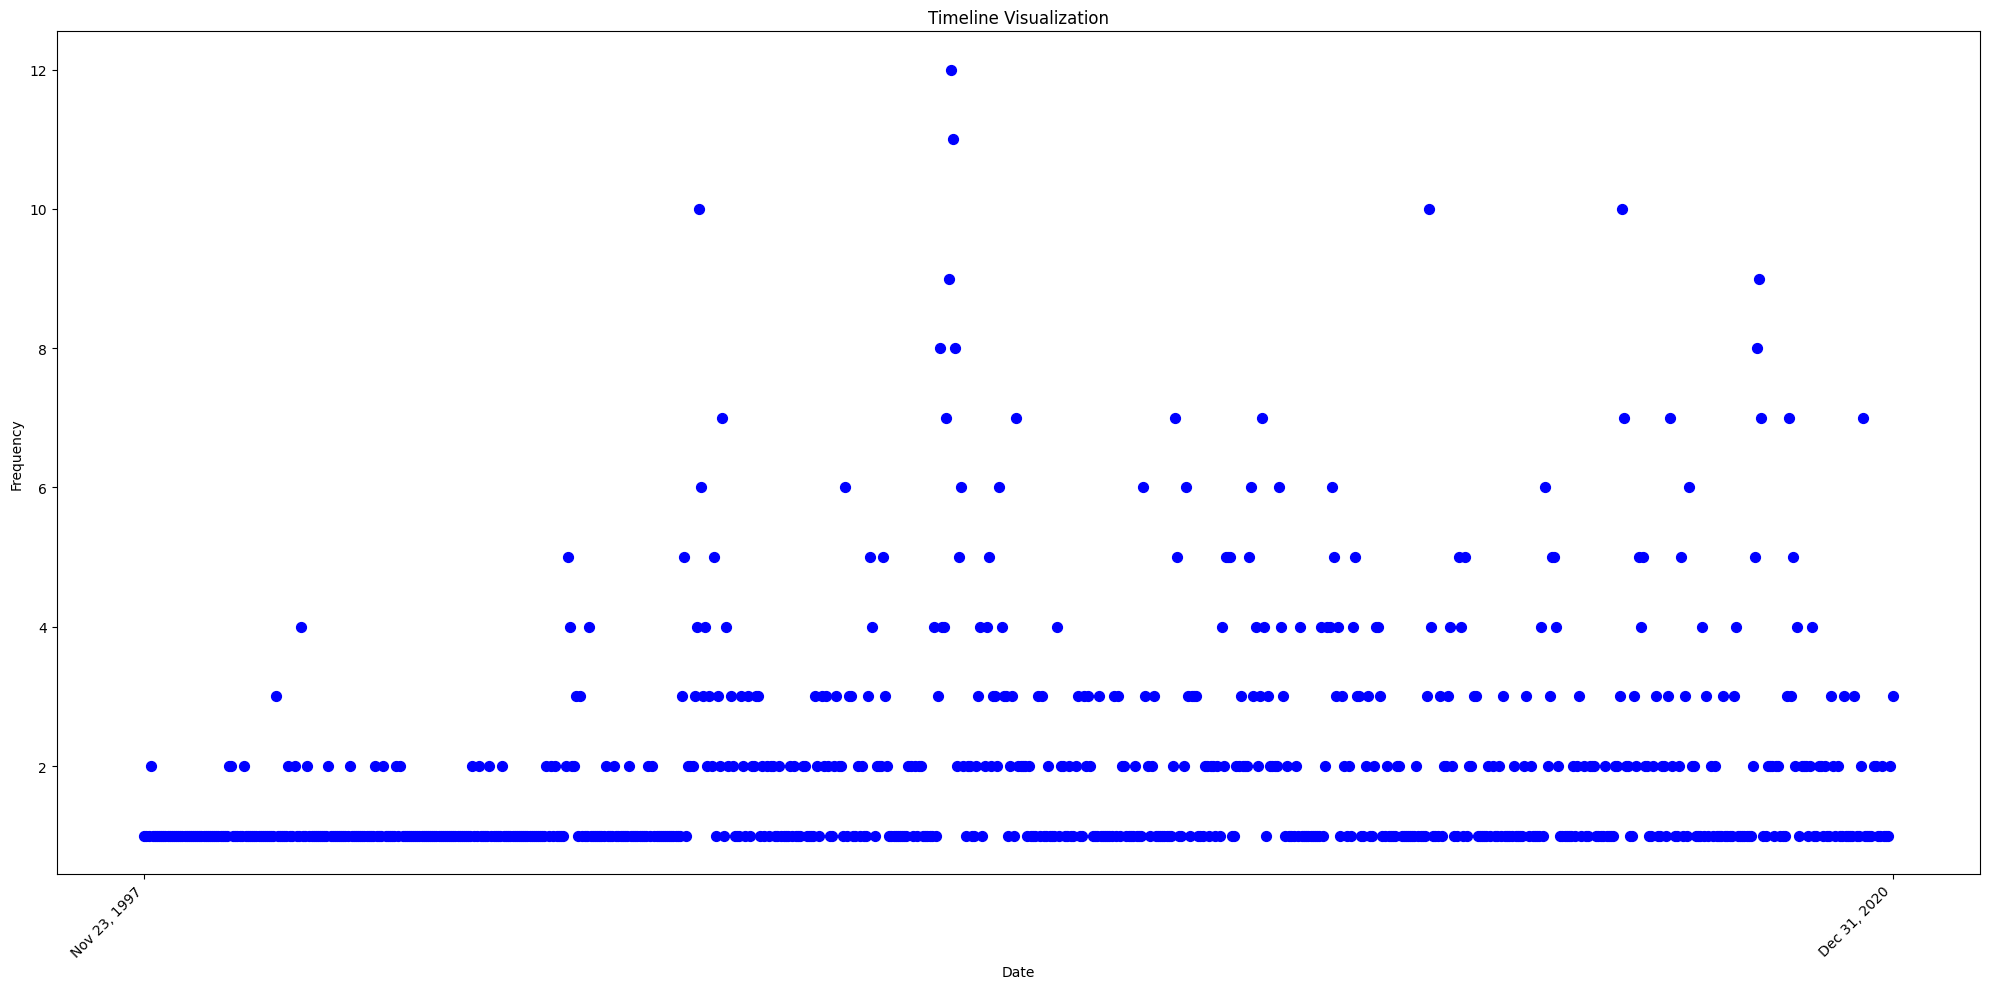

In [ ]:
vis_date(unique_list)